In [2]:
import numpy as np
import scipy
from activ import load_data
from activ.readfile import load_preprocessed, TrackTBIFile, encode
from activ.data_normalization import data_normalization
import pandas as pd
from sklearn import preprocessing
from collections import Counter
import h5py
from sklearn.datasets import load_digits, load_iris, load_breast_cancer, load_wine
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
mnist = load_digits()

In [22]:
mnist_data = mnist.data
mnist_target = mnist.target
mnist_labels = mnist.target_names

(1797, 64)


In [29]:
fname = '/Users/ahyeon/data/activ/mnist_data.h5'
TrackTBIFile.write(fname, mnist_data, mnist_data)

In [12]:
iris = load_iris()
iris_data = iris.data
TrackTBIFile.write('/Users/ahyeon/data/activ/iris_data.h5', iris_data, iris_data)

In [13]:
wine = load_wine()
wine_data = wine.data
TrackTBIFile.write('/Users/ahyeon/data/activ/wine_data.h5', wine_data, wine_data)

In [14]:
cancer = load_breast_cancer()
cancer_data = cancer.data
TrackTBIFile.write('/Users/ahyeon/data/activ/cancer_data.h5', cancer_data, cancer_data)

In [23]:
data = load_data()
data_bm = data.biomarkers
data_oc = data.outcomes

In [24]:
data_bm.shape

(247, 235)

In [41]:
fname = '/Users/ahyeon/Desktop/activ misc/mnist_results.h5'
f = h5py.File(fname, 'r')
acc = np.squeeze(f['score'][:], axis=1)

In [52]:
def conf(size, predicted, actual):
    
    conf = np.zeros((size,size))
    labs = list(map(int, actual[size-2]))
    preds = list(map(int, predicted[size-2]))
    for l, p in zip(labs, preds):
        conf[l,p] += 1
    
    return conf

In [54]:
# 1 iteration

predictions = np.squeeze(np.squeeze(f['score'][:], axis=1), axis=0)
norm_predictions = np.squeeze(np.squeeze(f['norm_score'][:], axis=1), axis=0)
cluster_sizes = f['cluster_sizes'][:]
labels = np.squeeze(np.squeeze(f['clusters'][:], axis=1), axis=0)
fold_over_chance = np.zeros((len(cluster_sizes)))
raw_acc = np.zeros((len(cluster_sizes)))
normalized_acc = np.zeros((len(cluster_sizes)))
print(predictions.shape, labels.shape)
for jj,c in enumerate(cluster_sizes):
    mat = conf(c, predictions, labels)
    norm_mat = conf(c, norm_predictions, labels)
    acc = accuracy(mat) 
    norm_acc = accuracy(norm_mat) 
    foc = acc/norm_acc
    fold_over_chance[jj] = foc
    raw_acc[jj] = acc
    normalized_acc[jj] = norm_acc

(49, 1797) (49, 1797)


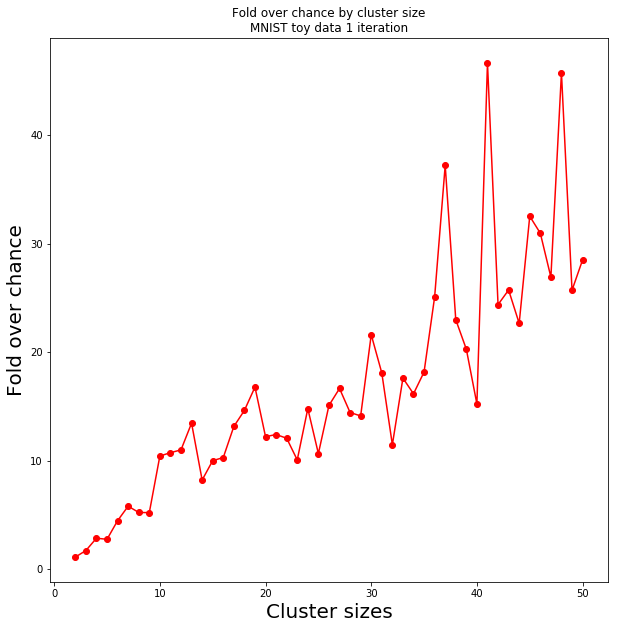

In [64]:
plt.figure(figsize=(10,10))
plt.plot(cluster_sizes, fold_over_chance, '-o', color='red')
# plt.plot(cluster_sizes, raw_acc, '-o', color='black')
# plt.plot(cluster_sizes, normalized_acc, '-o', color='grey')
plt.xlabel("Cluster sizes", fontsize=20)
plt.ylabel("Fold over chance", fontsize=20)
plt.title("Fold over chance by cluster size\nMNIST toy data 1 iteration")

In [16]:
def conf_alliter(size, predicted, actual):
    confalliter = []
    for j in range(50):
        conf = np.zeros((size,size))
        labs = list(map(int, actual[j][size-2]))
        preds = list(map(int, predicted[j][size-2]))
        for l, p in zip(labs, preds):
            conf[l,p] += 1
        confalliter.append(conf)
    return confalliter

def accuracy(mat):
    return mat.trace()/mat.sum()

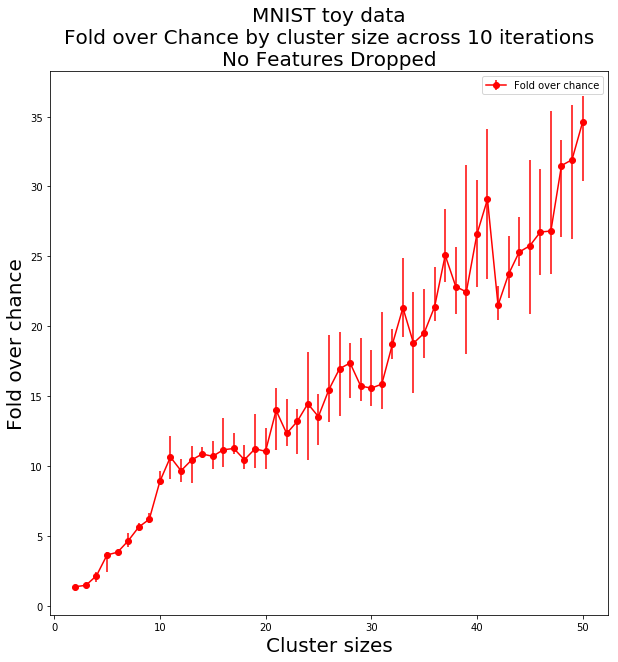

In [74]:
# 10 iterations

fname = '/Users/ahyeon/Desktop/activ misc/mnist_iter_10_results.h5'
f = h5py.File(fname, 'r')
acc = np.squeeze(f['score'][:], axis=1)
predictions = np.squeeze(f['score'][:], axis=1)
norm_predictions = np.squeeze(f['norm_score'][:], axis=1)
cluster_sizes = f['cluster_sizes'][:]
labels = np.squeeze(f['clusters'][:], axis=1)
fold_over_chance = np.zeros((len(cluster_sizes), 10))
raw_acc = np.zeros((len(cluster_sizes), 10))
normalized_acc = np.zeros((len(cluster_sizes), 10))
for jj,c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    acc = [accuracy(i) for i in all50mat]
    norm_acc = [accuracy(i) for i in norm_all50mat]
    foc = [float(x/y) for x, y in zip(acc, norm_acc)]
    fold_over_chance[jj,:] = foc
    raw_acc[jj,:] = acc
    normalized_acc[jj,:] = norm_acc


plt.rcParams["figure.figsize"] = [10,10]
cmap = plt.get_cmap("tab10")
lower = np.asarray([np.percentile(fold_over_chance[i,:], 25) for i in range(49)])
upper = np.asarray([np.percentile(fold_over_chance[i,:], 75) for i in range(49)])
med = np.median(fold_over_chance, axis=1)
raw_med = np.median(raw_acc, axis=1)
raw_lower = [np.percentile(raw_acc[i,:], 25) for i in range(49)]
raw_upper = [np.percentile(raw_acc[i,:], 75) for i in range(49)]
norm_med = np.median(normalized_acc, axis=1)
norm_lower = [np.percentile(normalized_acc[i,:], 25) for i in range(49)]
norm_upper = [np.percentile(normalized_acc[i,:], 75) for i in range(49)]
yerr = upper-lower

# plt.ylim((1, 4.5))
plt.errorbar(cluster_sizes, med, yerr=[med-lower,upper-med], color = 'red',fmt='-o', label='Fold over chance')
# plt.errorbar(cluster_sizes, raw_med, yerr=[raw_med-raw_lower,raw_upper-raw_med], color='black',fmt='-o', label='Raw accuracy')
# plt.errorbar(cluster_sizes, norm_med, yerr=[norm_med-norm_lower, norm_upper-norm_med], color='grey',fmt='-o', label='Chance accuracy')


plt.title("MNIST toy data\nFold over Chance by cluster size across 10 iterations\nNo Features Dropped", fontsize=20)
plt.xlabel("Cluster sizes", fontsize=20)
plt.ylabel("Fold over chance", fontsize=20)
plt.legend()

plt.savefig('/Users/ahyeon/Desktop/activ misc/mnist_foc.pdf')

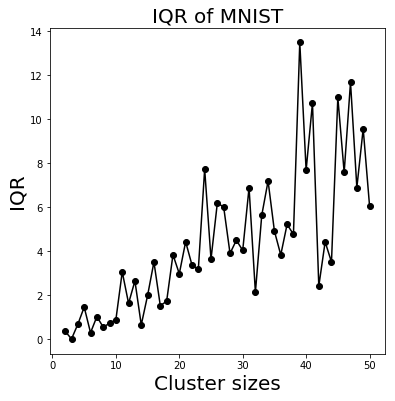

In [75]:
plt.figure(figsize=(6,6))
plt.plot(cluster_sizes, yerr, '-o', color='black')
plt.title("IQR of MNIST", fontsize=20)
plt.xlabel("Cluster sizes", fontsize=20)
plt.ylabel("IQR", fontsize=20)
plt.savefig('/Users/ahyeon/Desktop/activ misc/mnist_iqr.pdf')

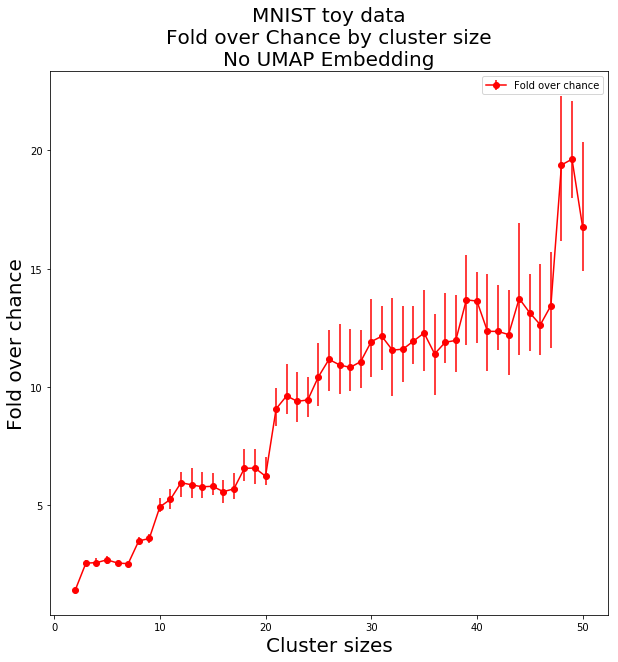

In [8]:
# 50 iterations no umap embedding

fname = '/Users/ahyeon/Desktop/activ misc/mnist_noumap_results.h5'
f = h5py.File(fname, 'r')
acc = np.squeeze(f['score'][:], axis=1)
predictions = np.squeeze(f['score'][:], axis=1)
norm_predictions = np.squeeze(f['norm_score'][:], axis=1)
cluster_sizes = f['cluster_sizes'][:]
labels = np.squeeze(f['clusters'][:], axis=1)
fold_over_chance = np.zeros((len(cluster_sizes), 50))
raw_acc = np.zeros((len(cluster_sizes), 50))
normalized_acc = np.zeros((len(cluster_sizes), 50))
for jj,c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    acc = [accuracy(i) for i in all50mat]
    norm_acc = [accuracy(i) for i in norm_all50mat]
    foc = [float(x/y) for x, y in zip(acc, norm_acc)]
    fold_over_chance[jj,:] = foc
    raw_acc[jj,:] = acc
    normalized_acc[jj,:] = norm_acc


plt.rcParams["figure.figsize"] = [10,10]
cmap = plt.get_cmap("tab10")
lower = np.asarray([np.percentile(fold_over_chance[i,:], 25) for i in range(49)])
upper = np.asarray([np.percentile(fold_over_chance[i,:], 75) for i in range(49)])
med = np.median(fold_over_chance, axis=1)
raw_med = np.median(raw_acc, axis=1)
raw_lower = [np.percentile(raw_acc[i,:], 25) for i in range(49)]
raw_upper = [np.percentile(raw_acc[i,:], 75) for i in range(49)]
norm_med = np.median(normalized_acc, axis=1)
norm_lower = [np.percentile(normalized_acc[i,:], 25) for i in range(49)]
norm_upper = [np.percentile(normalized_acc[i,:], 75) for i in range(49)]
yerr = upper-lower

# plt.ylim((1, 4.5))
plt.errorbar(cluster_sizes, med, yerr=[med-lower,upper-med], color = 'red',fmt='-o', label='Fold over chance')
# plt.errorbar(cluster_sizes, raw_med, yerr=[raw_med-raw_lower,raw_upper-raw_med], color='black',fmt='-o', label='Raw accuracy')
# plt.errorbar(cluster_sizes, norm_med, yerr=[norm_med-norm_lower, norm_upper-norm_med], color='grey',fmt='-o', label='Chance accuracy')


plt.title("MNIST toy data\nFold over Chance by cluster size\nNo UMAP Embedding", fontsize=20)
plt.xlabel("Cluster sizes", fontsize=20)
plt.ylabel("Fold over chance", fontsize=20)
plt.legend()

plt.savefig('/Users/ahyeon/Desktop/activ misc/mnist_noumap_foc.pdf')

/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


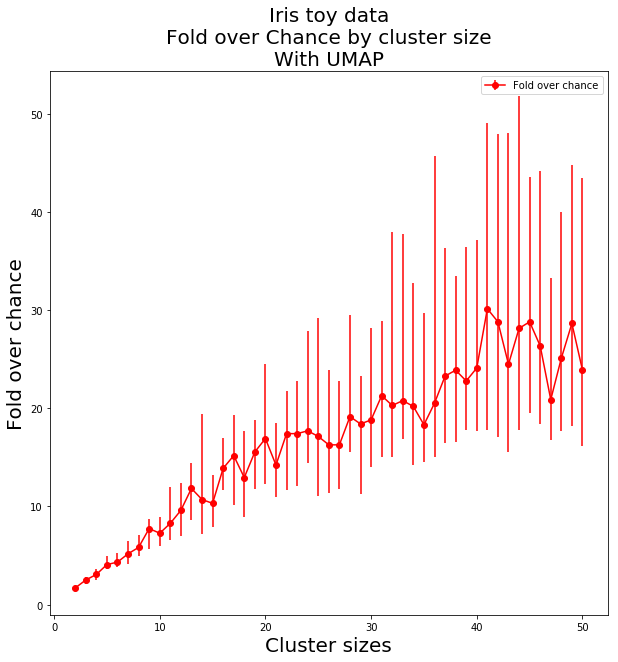

In [19]:
# iris with umap

fname = '/Users/ahyeon/Desktop/activ misc/iris_umap_results.h5'
f = h5py.File(fname, 'r')
acc = np.squeeze(f['score'][:], axis=1)
predictions = np.squeeze(f['score'][:], axis=1)
norm_predictions = np.squeeze(f['norm_score'][:], axis=1)
cluster_sizes = f['cluster_sizes'][:]
labels = np.squeeze(f['clusters'][:], axis=1)
fold_over_chance = np.zeros((len(cluster_sizes), 50))
raw_acc = np.zeros((len(cluster_sizes), 50))
normalized_acc = np.zeros((len(cluster_sizes), 50))
for jj,c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    acc = [accuracy(i) for i in all50mat]
    norm_acc = [accuracy(i) for i in norm_all50mat]
    foc = [float(x/y) for x, y in zip(acc, norm_acc)]
    fold_over_chance[jj,:] = foc
    raw_acc[jj,:] = acc
    normalized_acc[jj,:] = norm_acc


plt.rcParams["figure.figsize"] = [10,10]
cmap = plt.get_cmap("tab10")
lower = np.asarray([np.percentile(fold_over_chance[i,:], 25) for i in range(49)])
upper = np.asarray([np.percentile(fold_over_chance[i,:], 75) for i in range(49)])
med = np.median(fold_over_chance, axis=1)
raw_med = np.median(raw_acc, axis=1)
raw_lower = [np.percentile(raw_acc[i,:], 25) for i in range(49)]
raw_upper = [np.percentile(raw_acc[i,:], 75) for i in range(49)]
norm_med = np.median(normalized_acc, axis=1)
norm_lower = [np.percentile(normalized_acc[i,:], 25) for i in range(49)]
norm_upper = [np.percentile(normalized_acc[i,:], 75) for i in range(49)]
yerr = upper-lower

# plt.ylim((1, 4.5))
plt.errorbar(cluster_sizes, med, yerr=[med-lower,upper-med], color = 'red',fmt='-o', label='Fold over chance')
# plt.errorbar(cluster_sizes, raw_med, yerr=[raw_med-raw_lower,raw_upper-raw_med], color='black',fmt='-o', label='Raw accuracy')
# plt.errorbar(cluster_sizes, norm_med, yerr=[norm_med-norm_lower, norm_upper-norm_med], color='grey',fmt='-o', label='Chance accuracy')


plt.title("Iris toy data\nFold over Chance by cluster size\nWith UMAP", fontsize=20)
plt.xlabel("Cluster sizes", fontsize=20)
plt.ylabel("Fold over chance", fontsize=20)
plt.legend()

plt.savefig('/Users/ahyeon/Desktop/activ misc/iris_umap_foc.pdf')

/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


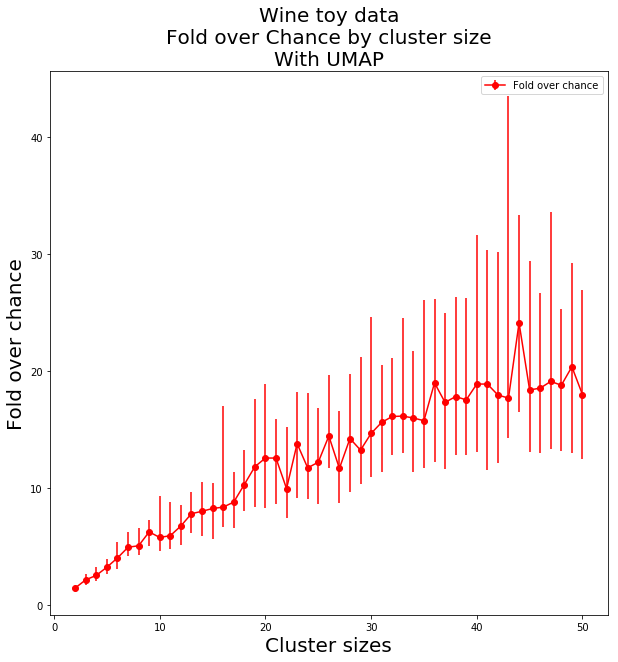

In [20]:
# wine with umap

fname = '/Users/ahyeon/Desktop/activ misc/wine_umap_results.h5'
f = h5py.File(fname, 'r')
acc = np.squeeze(f['score'][:], axis=1)
predictions = np.squeeze(f['score'][:], axis=1)
norm_predictions = np.squeeze(f['norm_score'][:], axis=1)
cluster_sizes = f['cluster_sizes'][:]
labels = np.squeeze(f['clusters'][:], axis=1)
fold_over_chance = np.zeros((len(cluster_sizes), 50))
raw_acc = np.zeros((len(cluster_sizes), 50))
normalized_acc = np.zeros((len(cluster_sizes), 50))
for jj,c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    acc = [accuracy(i) for i in all50mat]
    norm_acc = [accuracy(i) for i in norm_all50mat]
    foc = [float(x/y) for x, y in zip(acc, norm_acc)]
    fold_over_chance[jj,:] = foc
    raw_acc[jj,:] = acc
    normalized_acc[jj,:] = norm_acc


plt.rcParams["figure.figsize"] = [10,10]
cmap = plt.get_cmap("tab10")
lower = np.asarray([np.percentile(fold_over_chance[i,:], 25) for i in range(49)])
upper = np.asarray([np.percentile(fold_over_chance[i,:], 75) for i in range(49)])
med = np.median(fold_over_chance, axis=1)
raw_med = np.median(raw_acc, axis=1)
raw_lower = [np.percentile(raw_acc[i,:], 25) for i in range(49)]
raw_upper = [np.percentile(raw_acc[i,:], 75) for i in range(49)]
norm_med = np.median(normalized_acc, axis=1)
norm_lower = [np.percentile(normalized_acc[i,:], 25) for i in range(49)]
norm_upper = [np.percentile(normalized_acc[i,:], 75) for i in range(49)]
yerr = upper-lower

plt.errorbar(cluster_sizes, med, yerr=[med-lower,upper-med], color = 'red',fmt='-o', label='Fold over chance')

plt.title("Wine toy data\nFold over Chance by cluster size\nWith UMAP", fontsize=20)
plt.xlabel("Cluster sizes", fontsize=20)
plt.ylabel("Fold over chance", fontsize=20)
plt.legend()

plt.savefig('/Users/ahyeon/Desktop/activ misc/wine_umap_foc.pdf')

In [ ]:
# breast cancer with umap

fname = '/Users/ahyeon/Desktop/activ misc/cancer_umap_results.h5'
f = h5py.File(fname, 'r')
acc = np.squeeze(f['score'][:], axis=1)
predictions = np.squeeze(f['score'][:], axis=1)
norm_predictions = np.squeeze(f['norm_score'][:], axis=1)
cluster_sizes = f['cluster_sizes'][:]
labels = np.squeeze(f['clusters'][:], axis=1)
fold_over_chance = np.zeros((len(cluster_sizes), 50))
raw_acc = np.zeros((len(cluster_sizes), 50))
normalized_acc = np.zeros((len(cluster_sizes), 50))
for jj,c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    acc = [accuracy(i) for i in all50mat]
    norm_acc = [accuracy(i) for i in norm_all50mat]
    foc = [float(x/y) for x, y in zip(acc, norm_acc)]
    fold_over_chance[jj,:] = foc
    raw_acc[jj,:] = acc
    normalized_acc[jj,:] = norm_acc


plt.rcParams["figure.figsize"] = [10,10]
cmap = plt.get_cmap("tab10")
lower = np.asarray([np.percentile(fold_over_chance[i,:], 25) for i in range(49)])
upper = np.asarray([np.percentile(fold_over_chance[i,:], 75) for i in range(49)])
med = np.median(fold_over_chance, axis=1)
raw_med = np.median(raw_acc, axis=1)
raw_lower = [np.percentile(raw_acc[i,:], 25) for i in range(49)]
raw_upper = [np.percentile(raw_acc[i,:], 75) for i in range(49)]
norm_med = np.median(normalized_acc, axis=1)
norm_lower = [np.percentile(normalized_acc[i,:], 25) for i in range(49)]
norm_upper = [np.percentile(normalized_acc[i,:], 75) for i in range(49)]
yerr = upper-lower

plt.errorbar(cluster_sizes, med, yerr=[med-lower,upper-med], color = 'red',fmt='-o', label='Fold over chance')

plt.title("Breast cancer toy data\nFold over Chance by cluster size\nWith UMAP", fontsize=20)
plt.xlabel("Cluster sizes", fontsize=20)
plt.ylabel("Fold over chance", fontsize=20)
plt.legend()

plt.savefig('/Users/ahyeon/Desktop/activ misc/cancer_umap_foc.pdf')